In [1]:

!nvidia-smi

!pip install open3d scikit-learn

print("\nЗависимости установлены!")

Fri Dec 19 15:20:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

print("\nGoogle Drive успешно подключен!")

Mounted at /content/drive

Google Drive успешно подключен!


In [5]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import open3d as o3d
import matplotlib.pyplot as plt
from tqdm import tqdm


GDRIVE_PROJECT_PATH = '/content/drive/MyDrive/Colab_S3DIS'
RAW_DATA_PATH = GDRIVE_PROJECT_PATH
PROCESSED_DATA_PATH = os.path.join(GDRIVE_PROJECT_PATH, 's3dis_processed_area1')
OUTPUT_DIR = os.path.join(GDRIVE_PROJECT_PATH, 'outputs')
AREA_TO_PROCESS = 'Area_1'
NUM_CLASSES = 13
NUM_POINTS = 4096
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.001
LR_DECAY_STEP = 20
LR_DECAY_GAMMA = 0.5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = ['ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door',
           'table', 'chair', 'sofa', 'bookcase', 'board', 'clutter']
CLASS_TO_LABEL = {cls: i for i, cls in enumerate(CLASSES)}


def prepare_s3dis_data(raw_data_path, dest_path, area_name):

    area_path = os.path.join(raw_data_path, area_name)
    if not os.path.isdir(area_path):
        print(f"Ошибка: Директория с датасетом не найдена: {area_path}"); exit()
    os.makedirs(dest_path, exist_ok=True)
    print(f"Начало обработки {area_name}...")
    for room_folder in os.listdir(area_path):
        room_path = os.path.join(area_path, room_folder)
        if not os.path.isdir(room_path): continue
        annotations_path = os.path.join(room_path, 'Annotations')
        if not os.path.isdir(annotations_path): continue
        room_data_list = []
        object_files = [f for f in os.listdir(annotations_path) if f.endswith('.txt')]
        for object_file in tqdm(object_files, desc=f"Обработка {room_folder}"):
            object_name = object_file.split('_')[0]
            if object_name not in CLASS_TO_LABEL: continue
            label = CLASS_TO_LABEL[object_name]
            object_path = os.path.join(annotations_path, object_file)
            try:
                obj_data = np.loadtxt(object_path)
                labels = np.full((obj_data.shape[0], 1), label)
                room_data_list.append(np.hstack((obj_data, labels)))
            except Exception as e: print(f"Не удалось прочитать {object_path}: {e}")
        if not room_data_list: continue
        room_data = np.vstack(room_data_list)
        xyz, rgb, labels = room_data[:, :3], room_data[:, 3:6], room_data[:, 6]
        xyz_center = (np.amin(xyz, axis=0) + np.amax(xyz, axis=0)) / 2
        xyz -= xyz_center
        rgb /= 255.0
        processed_room_data = np.hstack((xyz, rgb, labels[:, np.newaxis]))
        save_filename = f"{area_name}_{room_folder}.npy"
        np.save(os.path.join(dest_path, save_filename), processed_room_data)
    print(f"\nОбработка данных завершена. Файлы сохранены в: {dest_path}")


def square_distance(src, dst):
    B, N, _ = src.shape; _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist
def index_points(points, idx):
    device = points.device; B = points.shape[0]
    view_shape = list(idx.shape); view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape); repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points
def farthest_point_sample(xyz, npoint):
    device = xyz.device; B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids
def query_ball_point(radius, nsample, xyz, new_xyz):
    device = xyz.device; B, N, C = xyz.shape; _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx
class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint, self.radius, self.nsample, self.group_all = npoint, radius, nsample, group_all
        self.mlp_convs, self.mlp_bns = nn.ModuleList(), nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
    def forward(self, xyz, points):
        xyz = xyz.permute(0, 2, 1)
        if points is not None: points = points.permute(0, 2, 1)
        if self.group_all: new_xyz, new_points = self.sample_and_group_all(xyz, points)
        else: new_xyz, new_points = self.sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)
        new_points = new_points.permute(0, 3, 2, 1)
        for i, conv in enumerate(self.mlp_convs): new_points = F.relu(self.mlp_bns[i](conv(new_points)))
        new_points = torch.max(new_points, 2)[0]
        new_xyz = new_xyz.permute(0, 2, 1)
        return new_xyz, new_points
    def sample_and_group(self, npoint, radius, nsample, xyz, points):
        B, N, C = xyz.shape; S = npoint
        new_xyz = index_points(xyz, farthest_point_sample(xyz, npoint))
        idx = query_ball_point(radius, nsample, xyz, new_xyz)
        grouped_xyz = index_points(xyz, idx)
        grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)
        if points is not None: new_points = torch.cat([grouped_xyz_norm, index_points(points, idx)], dim=-1)
        else: new_points = grouped_xyz_norm
        return new_xyz, new_points
    def sample_and_group_all(self, xyz, points):
        device = xyz.device; B, N, C = xyz.shape
        new_xyz = torch.zeros(B, 1, C).to(device)
        grouped_xyz = xyz.view(B, 1, N, C)
        if points is not None: new_points = torch.cat([grouped_xyz, points.view(B, 1, N, -1)], dim=-1)
        else: new_points = grouped_xyz
        return new_xyz, new_points
class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs, self.mlp_bns = nn.ModuleList(), nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel
    def forward(self, xyz1, xyz2, points1, points2):
        xyz1, xyz2, points2 = xyz1.permute(0, 2, 1), xyz2.permute(0, 2, 1), points2.permute(0, 2, 1)
        B, N, C = xyz1.shape; _, S, _ = xyz2.shape
        if S == 1: interpolated_points = points2.repeat(1, N, 1)
        else:
            dists = square_distance(xyz1, xyz2)
            dists, idx = dists.sort(dim=-1); dists, idx = dists[:, :, :3], idx[:, :, :3]
            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm
            interpolated_points = torch.sum(index_points(points2, idx) * weight.view(B, N, 3, 1), dim=2)
        if points1 is not None: new_points = torch.cat([points1.permute(0, 2, 1), interpolated_points], dim=-1)
        else: new_points = interpolated_points
        new_points = new_points.permute(0, 2, 1)
        for i, conv in enumerate(self.mlp_convs): new_points = F.relu(self.mlp_bns[i](conv(new_points)))
        return new_points
class PointNet2SemSeg(nn.Module):
    def __init__(self, num_classes):
        super(PointNet2SemSeg, self).__init__()

        # Каналы на входе = 3 (xyz) + 6 (rgb) = 9
        self.sa1 = PointNetSetAbstraction(1024, 0.1, 32, 9, [32, 32, 64], False)

        self.sa2 = PointNetSetAbstraction(256, 0.2, 32, 64 + 3, [64, 64, 128], False)
        self.sa3 = PointNetSetAbstraction(64, 0.4, 32, 128 + 3, [128, 128, 256], False)
        self.sa4 = PointNetSetAbstraction(16, 0.8, 32, 256 + 3, [256, 256, 512], False)
        self.fp4 = PointNetFeaturePropagation(768, [256, 256])
        self.fp3 = PointNetFeaturePropagation(384, [256, 256])
        self.fp2 = PointNetFeaturePropagation(320, [256, 128])
        self.fp1 = PointNetFeaturePropagation(128 + 6, [128, 128, 128])
        self.conv1 = nn.Conv1d(128, 128, 1); self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5); self.conv2 = nn.Conv1d(128, num_classes, 1)
    def forward(self, xyz):
        l0_points, l0_xyz = xyz, xyz[:,:3,:]
        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        l4_xyz, l4_points = self.sa4(l3_xyz, l3_points)
        l3_points = self.fp4(l3_xyz, l4_xyz, l3_points, l4_points)
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, l0_points, l1_points)
        x = self.drop1(F.relu(self.bn1(self.conv1(l0_points))))
        x = self.conv2(x)
        x = F.log_softmax(x, dim=1)
        return x.permute(0, 2, 1)


class S3DISDataset(Dataset):
    def __init__(self, split='train', data_root=PROCESSED_DATA_PATH, num_points=NUM_POINTS):
ё
        self.num_points = num_points
        all_files = sorted([os.path.join(data_root, f) for f in os.listdir(data_root)])
        np.random.seed(42); indices = np.arange(len(all_files)); np.random.shuffle(indices)
        num_rooms = len(all_files); train_split = int(0.7 * num_rooms); val_split = int(0.85 * num_rooms)
        train_idx, val_idx, test_idx = indices[:train_split], indices[train_split:val_split], indices[val_split:]
        if split == 'train': self.room_files = [all_files[i] for i in train_idx]
        elif split == 'val': self.room_files = [all_files[i] for i in val_idx]
        else: self.room_files = [all_files[i] for i in test_idx]
        self.room_data = [np.load(path) for path in self.room_files]
        print(f"Инициализирован '{split}' датасет с {len(self.room_data)} комнатами.")
    def __len__(self): return len(self.room_data)
    def __getitem__(self, index):
        points_labels = self.room_data[index]
        choice = np.random.choice(len(points_labels), self.num_points, replace=len(points_labels) < self.num_points)
        points_labels = points_labels[choice, :]
        points, labels = points_labels[:, :6], points_labels[:, 6]
        theta = np.random.uniform(0, 2 * np.pi)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        points[:, [0, 2]] = points[:, [0, 2]].dot(rotation_matrix)
        return torch.from_numpy(points).float().transpose(1, 0), torch.from_numpy(labels).long()


def calculate_metrics(all_preds, all_labels, num_classes):

    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    oa = np.sum(np.diag(cm)) / np.sum(cm) if np.sum(cm) > 0 else 0
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.diag(cm) / (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
    miou = np.nanmean(iou)
    return oa, miou, iou
def visualize_results(points, labels_gt, labels_pred, room_name):

    colors = plt.get_cmap("tab20")(np.linspace(0, 1, NUM_CLASSES))[:, :3]
    pcd_orig = o3d.geometry.PointCloud(); pcd_orig.points = o3d.utility.Vector3dVector(points[:,:3]); pcd_orig.colors = o3d.utility.Vector3dVector(points[:,3:6])
    o3d.io.write_point_cloud(os.path.join(OUTPUT_DIR, f"{room_name}_original.ply"), pcd_orig)
    pcd_gt = o3d.geometry.PointCloud(); pcd_gt.points = o3d.utility.Vector3dVector(points[:,:3]); pcd_gt.colors = o3d.utility.Vector3dVector(colors[labels_gt])
    o3d.io.write_point_cloud(os.path.join(OUTPUT_DIR, f"{room_name}_ground_truth.ply"), pcd_gt)
    pcd_pred = o3d.geometry.PointCloud(); pcd_pred.points = o3d.utility.Vector3dVector(points[:,:3]); pcd_pred.colors = o3d.utility.Vector3dVector(colors[labels_pred])
    o3d.io.write_point_cloud(os.path.join(OUTPUT_DIR, f"{room_name}_prediction.ply"), pcd_pred)
    print(f"Сохранены файлы визуализации для {room_name}")


print("Все определения загружены.")

Все определения загружены.


In [6]:

os.makedirs(OUTPUT_DIR, exist_ok=True)

if not os.path.exists(PROCESSED_DATA_PATH) or not os.listdir(PROCESSED_DATA_PATH):
    print("--- Обработанные данные не найдены. Запускаю подготовку... ---")
    prepare_s3dis_data(RAW_DATA_PATH, PROCESSED_DATA_PATH, AREA_TO_PROCESS)
else:
    print("--- Обработанные данные уже существуют. Пропускаю этап подготовки. ---")

--- Обработанные данные уже существуют. Пропускаю этап подготовки. ---



--- Создание загрузчиков данных... ---
Инициализирован 'train' датасет с 30 комнатами.
Инициализирован 'val' датасет с 7 комнатами.
Инициализирован 'test' датасет с 7 комнатами.
Используемое устройство: cuda

--- Инициализация и обучение модели... ---


Эпоха 1/50 [Обучение]: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, loss=2.4629]


Эпоха 1/50 -> Train Loss: 2.6198, Val Loss: 2.5393
Модель сохранена как лучшая.


Эпоха 2/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, loss=2.2659]


Эпоха 2/50 -> Train Loss: 2.3710, Val Loss: 2.5038
Модель сохранена как лучшая.


Эпоха 3/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, loss=2.1585]


Эпоха 3/50 -> Train Loss: 2.1653, Val Loss: 2.4770
Модель сохранена как лучшая.


Эпоха 4/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, loss=2.0401]


Эпоха 4/50 -> Train Loss: 1.9977, Val Loss: 2.5021


Эпоха 5/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s, loss=1.8722]


Эпоха 5/50 -> Train Loss: 2.0312, Val Loss: 2.4796


Эпоха 6/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, loss=2.0461]


Эпоха 6/50 -> Train Loss: 1.8911, Val Loss: 2.5214


Эпоха 7/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, loss=2.1518]


Эпоха 7/50 -> Train Loss: 1.9264, Val Loss: 2.4563
Модель сохранена как лучшая.


Эпоха 8/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s, loss=1.9248]


Эпоха 8/50 -> Train Loss: 1.7761, Val Loss: 2.3178
Модель сохранена как лучшая.


Эпоха 9/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s, loss=1.9486]


Эпоха 9/50 -> Train Loss: 1.7933, Val Loss: 2.2536
Модель сохранена как лучшая.


Эпоха 10/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, loss=1.5832]


Эпоха 10/50 -> Train Loss: 1.6913, Val Loss: 2.1547
Модель сохранена как лучшая.


Эпоха 11/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, loss=1.5750]


Эпоха 11/50 -> Train Loss: 1.7554, Val Loss: 2.0672
Модель сохранена как лучшая.


Эпоха 12/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, loss=1.6528]


Эпоха 12/50 -> Train Loss: 1.6771, Val Loss: 2.0185
Модель сохранена как лучшая.


Эпоха 13/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, loss=1.5370]


Эпоха 13/50 -> Train Loss: 1.6534, Val Loss: 2.0587


Эпоха 14/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, loss=1.4403]


Эпоха 14/50 -> Train Loss: 1.6113, Val Loss: 2.0266


Эпоха 15/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, loss=1.6261]


Эпоха 15/50 -> Train Loss: 1.5798, Val Loss: 2.0033
Модель сохранена как лучшая.


Эпоха 16/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, loss=1.8037]


Эпоха 16/50 -> Train Loss: 1.6470, Val Loss: 2.1104


Эпоха 17/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s, loss=1.5869]


Эпоха 17/50 -> Train Loss: 1.5860, Val Loss: 2.2950


Эпоха 18/50 [Обучение]: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, loss=1.4250]


Эпоха 18/50 -> Train Loss: 1.6055, Val Loss: 2.1604


Эпоха 19/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, loss=1.7690]


Эпоха 19/50 -> Train Loss: 1.5213, Val Loss: 2.1610


Эпоха 20/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s, loss=1.5502]


Эпоха 20/50 -> Train Loss: 1.5094, Val Loss: 2.0042


Эпоха 21/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, loss=1.5804]


Эпоха 21/50 -> Train Loss: 1.5055, Val Loss: 1.9983
Модель сохранена как лучшая.


Эпоха 22/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, loss=1.4153]


Эпоха 22/50 -> Train Loss: 1.4861, Val Loss: 2.0373


Эпоха 23/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, loss=1.5310]


Эпоха 23/50 -> Train Loss: 1.4924, Val Loss: 1.9135
Модель сохранена как лучшая.


Эпоха 24/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, loss=1.2684]


Эпоха 24/50 -> Train Loss: 1.4182, Val Loss: 1.8557
Модель сохранена как лучшая.


Эпоха 25/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, loss=1.5411]


Эпоха 25/50 -> Train Loss: 1.4321, Val Loss: 1.8488
Модель сохранена как лучшая.


Эпоха 26/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, loss=1.3110]


Эпоха 26/50 -> Train Loss: 1.4440, Val Loss: 1.9846


Эпоха 27/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s, loss=1.3097]


Эпоха 27/50 -> Train Loss: 1.4444, Val Loss: 2.1166


Эпоха 28/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, loss=1.7336]


Эпоха 28/50 -> Train Loss: 1.5071, Val Loss: 2.1292


Эпоха 29/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, loss=1.4159]


Эпоха 29/50 -> Train Loss: 1.4191, Val Loss: 2.2657


Эпоха 30/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, loss=1.3885]


Эпоха 30/50 -> Train Loss: 1.3998, Val Loss: 2.1273


Эпоха 31/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, loss=1.4498]


Эпоха 31/50 -> Train Loss: 1.4446, Val Loss: 2.0473


Эпоха 32/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=1.1400]


Эпоха 32/50 -> Train Loss: 1.3789, Val Loss: 1.9487


Эпоха 33/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, loss=1.2464]


Эпоха 33/50 -> Train Loss: 1.3717, Val Loss: 1.8901


Эпоха 34/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, loss=1.2864]


Эпоха 34/50 -> Train Loss: 1.3498, Val Loss: 1.9740


Эпоха 35/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, loss=1.7892]


Эпоха 35/50 -> Train Loss: 1.4235, Val Loss: 1.9395


Эпоха 36/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, loss=1.7406]


Эпоха 36/50 -> Train Loss: 1.4160, Val Loss: 2.0242


Эпоха 37/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, loss=1.3364]


Эпоха 37/50 -> Train Loss: 1.3403, Val Loss: 2.1520


Эпоха 38/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, loss=1.3709]


Эпоха 38/50 -> Train Loss: 1.4157, Val Loss: 2.1681


Эпоха 39/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, loss=1.3541]


Эпоха 39/50 -> Train Loss: 1.3290, Val Loss: 2.1954


Эпоха 40/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, loss=1.3140]


Эпоха 40/50 -> Train Loss: 1.3128, Val Loss: 2.0492


Эпоха 41/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, loss=1.1985]


Эпоха 41/50 -> Train Loss: 1.2675, Val Loss: 2.0726


Эпоха 42/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, loss=1.3639]


Эпоха 42/50 -> Train Loss: 1.3378, Val Loss: 2.0512


Эпоха 43/50 [Обучение]: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s, loss=1.2900]


Эпоха 43/50 -> Train Loss: 1.3533, Val Loss: 1.9759


Эпоха 44/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, loss=1.4232]


Эпоха 44/50 -> Train Loss: 1.2504, Val Loss: 2.0156


Эпоха 45/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, loss=1.3205]


Эпоха 45/50 -> Train Loss: 1.2345, Val Loss: 1.9570


Эпоха 46/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, loss=1.2417]


Эпоха 46/50 -> Train Loss: 1.2504, Val Loss: 1.9338


Эпоха 47/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, loss=1.2193]


Эпоха 47/50 -> Train Loss: 1.3129, Val Loss: 1.9842


Эпоха 48/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, loss=1.6558]


Эпоха 48/50 -> Train Loss: 1.2916, Val Loss: 1.9815


Эпоха 49/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, loss=1.1518]


Эпоха 49/50 -> Train Loss: 1.2374, Val Loss: 1.9892


Эпоха 50/50 [Обучение]: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, loss=1.1446]


Эпоха 50/50 -> Train Loss: 1.1930, Val Loss: 2.0414

--- Тестирование модели... ---


Тестирование: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



OA: 0.4816, mIoU: 0.1831. Метрики сохранены в /content/drive/MyDrive/Colab_S3DIS/outputs.

--- Создание файлов для визуализации... ---
Сохранены файлы визуализации для Area_1_office_15


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.91 GiB. GPU 0 has a total capacity of 14.74 GiB of which 792.12 MiB is free. Process 16016 has 13.96 GiB memory in use. Of the allocated memory 13.71 GiB is allocated by PyTorch, and 133.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

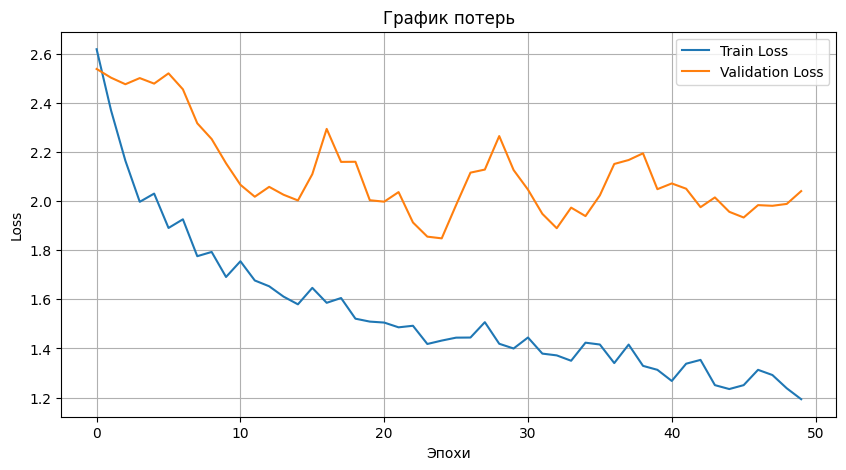

In [7]:

print("\n--- Создание загрузчиков данных... ---")
train_dataset = S3DISDataset('train')
val_dataset = S3DISDataset('val')
test_dataset = S3DISDataset('test')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"Используемое устройство: {DEVICE}")

print("\n--- Инициализация и обучение модели... ---")
model = PointNet2SemSeg(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_DECAY_STEP, gamma=LR_DECAY_GAMMA)
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]")
    for points, labels in pbar:
        points, labels = points.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        preds = model(points).contiguous().view(-1, NUM_CLASSES)
        loss = criterion(preds, labels.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    history['train_loss'].append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for points, labels in val_loader:
            points, labels = points.to(DEVICE), labels.to(DEVICE)
            preds = model(points).contiguous().view(-1, NUM_CLASSES)
            loss = criterion(preds, labels.view(-1))
            val_loss += loss.item()
    val_loss /= len(val_loader)
    history['val_loss'].append(val_loss)

    print(f"Эпоха {epoch+1}/{EPOCHS} -> Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pth'))
        print("Модель сохранена как лучшая.")


print("\n--- Тестирование модели... ---")
plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('График потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_chart.png'))

model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth')))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for points, labels in tqdm(test_loader, "Тестирование"):
        preds = torch.argmax(model(points.to(DEVICE)), dim=2)
        all_preds.append(preds.cpu().numpy().flatten())
        all_labels.append(labels.numpy().flatten())
all_preds, all_labels = np.concatenate(all_preds), np.concatenate(all_labels)
oa, miou, iou = calculate_metrics(all_preds, all_labels, NUM_CLASSES)
with open(os.path.join(OUTPUT_DIR, 'test_metrics.txt'), 'w', encoding='utf-8') as f:
    f.write(f"Overall Accuracy (OA): {oa:.4f}\nMean IoU (mIoU): {miou:.4f}\n\n--- IoU по классам ---\n")
    for i, class_iou in enumerate(iou):
        f.write(f"{CLASSES[i]:<15}: {class_iou:.4f}\n")
print(f"\nOA: {oa:.4f}, mIoU: {miou:.4f}. Метрики сохранены в {OUTPUT_DIR}.")


print("\n--- Создание файлов для визуализации... ---")
num_visualizations = min(3, len(test_dataset.room_data))
for i in range(num_visualizations):
    full_room_data = test_dataset.room_data[i]
    points_tensor = torch.from_numpy(full_room_data[:,:6]).float().transpose(1,0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = torch.argmax(model(points_tensor), dim=2).squeeze(0).cpu().numpy()
    room_name = os.path.basename(test_dataset.room_files[i]).replace('.npy', '')
    visualize_results(full_room_data[:,:6], full_room_data[:,6].astype(int), preds, room_name)

print(f"\n\nРабота завершена! Все результаты сохранены в вашей папке Google Drive: {OUTPUT_DIR}")

In [8]:

print("--- Загрузка определений и сохраненной модели... ---")


model = PointNet2SemSeg(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth')))
model.eval()


test_dataset = S3DISDataset('test')
print(f"Найдено {len(test_dataset.room_data)} комнат для визуализации.")

num_visualizations = min(3, len(test_dataset.room_data))
for i in range(num_visualizations):

    full_room_data = test_dataset.room_data[i]
    room_name = os.path.basename(test_dataset.room_files[i]).replace('.npy', '')
    print(f"\n--- Создание визуализации для: {room_name} ({len(full_room_data)} точек) ---")


    chunk_size = 16384 # Обрабатываем по 16384 точек за раз
    all_preds_list = []

    with torch.no_grad():
        # Делим большое облако на маленькие части
        for start_idx in tqdm(range(0, len(full_room_data), chunk_size), desc="Обработка чанков"):
            end_idx = min(start_idx + chunk_size, len(full_room_data))
            chunk_data = full_room_data[start_idx:end_idx, :]


            points_tensor = torch.from_numpy(chunk_data[:,:6]).float().transpose(1,0).unsqueeze(0).to(DEVICE)


            preds_chunk = torch.argmax(model(points_tensor), dim=2).squeeze(0).cpu().numpy()
            all_preds_list.append(preds_chunk)

    final_preds = np.concatenate(all_preds_list, axis=0)


    visualize_results(full_room_data[:,:6], full_room_data[:,6].astype(int), final_preds, room_name)

print("\n\nВсе визуализации успешно созданы и сохранены!")

--- Загрузка определений и сохраненной модели... ---
Инициализирован 'test' датасет с 7 комнатами.
Найдено 7 комнат для визуализации.

--- Создание визуализации для: Area_1_office_15 (46390 точек) ---


Обработка чанков: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Сохранены файлы визуализации для Area_1_office_15

--- Создание визуализации для: Area_1_pantry_1 (511880 точек) ---


Обработка чанков: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Сохранены файлы визуализации для Area_1_pantry_1

--- Создание визуализации для: Area_1_office_17 (196749 точек) ---


Обработка чанков: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


Сохранены файлы визуализации для Area_1_office_17


Все визуализации успешно созданы и сохранены!


In [10]:

!apt-get install -y libosmesa6-dev libgl1-mesa-glx patchelf

print("\nГрафические библиотеки успешно установлены!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
The following additional packages will be installed:
  libdrm-dev libgl-dev libglx-dev libosmesa6 libpciaccess-dev mesa-common-dev
The following NEW packages will be installed:
  libdrm-dev libgl-dev libglx-dev libosmesa6 libosmesa6-dev libpciaccess-dev
  mesa-common-dev patchelf
0 upgraded, 8 newly installed, 0 to remove and 41 not upgraded.
Need to get 5,833 kB of archives.
After this operation, 18.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpciaccess-dev amd64 0.16-3 [21.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdrm-dev amd64 2.4.113-2~ubuntu0.22.04.1 [292 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1